In [1]:
import numpy as np

In [2]:
import heron
import heron.models.georgebased

/home/daniel/.virtualenvs/IGRlaptop21/heron3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/daniel/.virtualenvs/IGRlaptop21/heron3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
generator = heron.models.georgebased.HeronHodlr()

In [4]:
times = np.linspace(-0.02, 0.05, 1000)

In [5]:
generator.training_data[:,0]/100

array([-0.01489258, -0.01391602, -0.01293945, ...,  0.01733398,
        0.01831055,  0.01928711])

In [6]:
hp, hx = generator.mean({"mass ratio": 1}, times)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


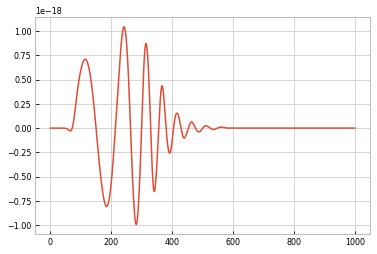

In [8]:
plt.plot(hp.data)

In [36]:
4000*0.06

240.0

In [52]:
stimes = np.linspace(-0.05, 0.01, 70)
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

In [53]:
%%timeit
hp, hx = generator.bilby(stimes, 65, 22, 1000).values()

271 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


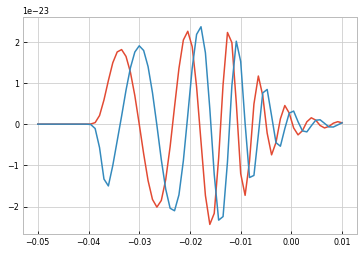

In [54]:
plt.plot(stimes, hp)
plt.plot(stimes, hx)

In [11]:
import bilby

16:12 bilby INFO    : Running bilby version: 0.5.6:
16:12 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
16:12 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
16:12 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.


In [12]:
from astropy import constants as c
def heronbilby(time, mass_ratio, chirp_mass, luminosity_distance):
        """
        Return a waveform from the GPR in a format expected by the Bilby ecosystem
        """

        times_b = time.copy()
        #times_b -= generator.t_min
        
    
        total_mass_cat = generator.total_mass
        time_factor_cat = (c.c.value**3 / c.G.value)/(total_mass_cat*c.M_sun.value) #*1e4
        #h_factor = c.pc.value
        
        total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(chirp_mass, mass_ratio)
                
    
        time_factor = (c.c.value**3 / c.G.value)/(total_mass*c.M_sun.value) 
    
        times_b *= (total_mass_cat / total_mass) #(time_factor/time_factor_cat)

        p = {'mass ratio': 1,
            'spin 1x': 0,  'spin 1y': 0,  'spin 1z': 0,
            'spin 2x': 0,  'spin 2y': 0,  'spin 2z': 0}

        p['mass ratio'] = mass_ratio
        
        mean = generator.mean(p=p, times = times_b)
    
        return {"plus": mean[0].data / luminosity_distance , "cross": mean[1].data / luminosity_distance}

In [57]:
duration = 0.06
sampling_frequency = 1000
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=heronbilby,
    start_time=-0.05)

In [63]:
# inject the signal into three interferometers
ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=0)

In [64]:
injection_parameters = {"mass_1": 10, "mass_2": 15, "luminosity_distance": 1000, "geocent_time": 0, "ra": 10, "dec": 0, "psi": 0}
ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters);

14:35 bilby INFO    : Injected signal in L1:
14:35 bilby INFO    :   optimal SNR = 9.54
14:35 bilby INFO    :   matched filter SNR = 10.84+0.82j
14:35 bilby INFO    :   mass_1 = 10
14:35 bilby INFO    :   mass_2 = 15
14:35 bilby INFO    :   luminosity_distance = 1000
14:35 bilby INFO    :   geocent_time = 0
14:35 bilby INFO    :   ra = 10
14:35 bilby INFO    :   dec = 0
14:35 bilby INFO    :   psi = 0


In [65]:
priors = bilby.gw.prior.BBHPriorDict()

14:35 bilby INFO    : No prior given, using default BBH priors in /home/daniel/.virtualenvs/IGRlaptop21/heron3/lib/python3.6/site-packages/bilby/gw/prior_files/binary_black_holes.prior.


In [67]:
outdir="test_heron-2"
label="pe-test"

priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=injection_parameters['geocent_time'] - 1,
    maximum=injection_parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'theta_jn',
            'dec', 'geocent_time', 'phase']:
    if key in injection_parameters:
        priors[key] = injection_parameters[key]
    priors[key] = 0 #injection_parameters[key]

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

In [68]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=10,
    injection_parameters=injection_parameters, outdir=outdir, label=label)

14:36 bilby INFO    : Running for label 'pe-test', output will be saved to 'test_heron-2'
14:36 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.62;Id: a75e6c243c5695e1abdcc4e5d91f623cf0db1d22;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
14:36 bilby INFO    : Search parameters:
14:36 bilby INFO    :   mass_1 = Uniform(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit='$M_{\\odot}$', boundary=None)
14:36 bilby INFO    :   mass_2 = Uniform(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit='$M_{\\odot}$', boundary=None)
14:36 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
14:36 bilby INFO    :   mass_ratio = Constraint(minimum=0.125, maximum=1, name='mass

 61| logz ratio=-0.782 +/-  0.492 | dlogz:  0.106 >  0.100

14:42 bilby INFO    : Writing checkpoint file test_heron-2/pe-test_resume.pickle


 61| logz ratio=-0.704 +/-  0.533 | dlogz:  0.008 >  0.100

14:42 bilby INFO    : Sampling time: 0:05:43.143220
14:42 bilby INFO    : Summary of results:
nsamples: 71
log_noise_evidence: -90.963
log_evidence: -91.667 +/-  0.533
log_bayes_factor: -0.704 +/-  0.533



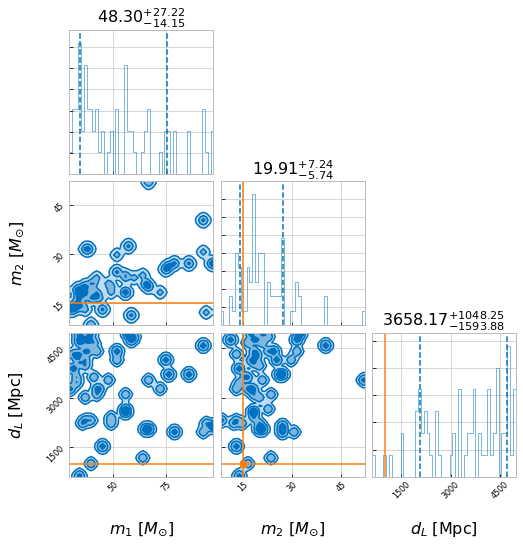

In [69]:
# Make a corner plot.
result.plot_corner()